# Selecting data & finding the most common complaint type

## Install

In [1]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /


✅ The installed version of syft==0.8.1b9 matches the requirement >=0.8.1b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-2", port=9082, reset=True)

Starting pandas-test-domain-2 server on 0.0.0.0:9082


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /


Waiting for server to start..SQLite Store Path:
!open file:///var/folders/f1/h55w4kj150x0s8c3jwhkkygw0000gn/T/f8ee11b1f98b4d79917dd97242823eb4.sqlite

. Done.


# Data Owner: Upload data

In [4]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [5]:
from syft.serde.mock import CachedFaker
from random import randint
from syft.util.util import PANDAS_DATA
from syft.service.project.project import Project
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [7]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(sy.autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

url https://raw.githubusercontent.com/OpenMined/datasets/main/pandas_cookbook/311-service-requests_small.csv


Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [8]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,26589026,10/30/2013 11:37:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/

## Create Mock data

Let's create the mock data for the complaint dataset.

In [9]:
fake = CachedFaker()

In [10]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [11]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [12]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [13]:
mock = pd.DataFrame(data=mock_data)

In [14]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,859795,10/31/2013 12:30:31 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Broken Glass,Park/Playground,11219,AVENUE J,RIVINGTON STREET,LYMAN AVENUE,BROADWAY,WEST 54 STREET,CASS PLACE,BLOCKFACE,STATEN ISLAND,NaN,Precinct,Closed,10/31/2013 08:12:08 AM,10/31/2013 02:58:55 AM,05 BROOKLYN,BROOKLYN,779983,908749,Unspecified,QUEENS,Unspecified,B099,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,Other,NaN,NaN,NaN,GrandCentral Pkwy/VanWyck Expwy/College Point ...,NaN,NaN,NaN,40.66820406598287,-73.98731595609806,"(-18.943714, -32.796366)"
1,740695,10/31/2013 01:44:19 AM,10/31/2013 01:05:42 AM,DOHMH,HRA Benefit Card Replacement,'Animal in a Park',Broken Fence,Residential Building/House,10011,1175 MORRIS AVENUE,WEST 207TH STREET,78 STREET,8 AVENUE,WEST 184 STREET,ATLANTIC AVENUE,BLOCKFACE,SAINT ALBANS,NaN,Precinct,Open,10/31/2013 07:55:03 AM,10/31/2013 12:25:00 AM,03 STATEN ISLAND,Unspecified,692431,307686,Unspecified,Unspecified,Unspecified,B102,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,NaN,NaN,NaN,NaN,Other,NaN,NaN,NaN,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,NaN,NaN,NaN,40.74003415280169,-73.83173699701601,"(-74.988303, 157.820163)"
2,396288,10/31/2013 01:20:57 AM,10/31/2013 01:13:45 AM,NYPD,HRA Benefit Card Replacement,Noise - Street/Sidewalk,Broken Fence,House of Worship,11211,115-14 197 STREET,EAST 99 STREET,AVENUE F,GAY STREET,WALL STREET,CASS PLACE,NaN,MIDDLE VILLAGE,NaN,Precinct,Pending,10/31/2013 09:20:13 AM,10/31/2013 12:00:00 AM,06 MANHATTAN,QUEENS,345225,567102,Unspecified,BROOKLYN,Unspecified,B073,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,Other,NaN,NaN,NaN,GrandCentral Pkwy/VanWyck Expwy/College Point ...,NaN,NaN,NaN,40.81271725522785,-73.92833741848976,"(-22.777593, -84.540657)"
3,420528,10/31/2013 01:24:14 AM,10/30/2013 11:57:00 PM,DPR,Taxi and Limousine Commission,'Animal in a Park',Broken Fence,NYC Street Address,10453,917 MACE AVENUE,EAST TREMONT AVENUE,EMERSON PLACE,WINEGAR LANE,WEST 99 STREET,7 AVENUE,BLOCKFACE,WOODHAVEN,NaN,DSNY Garage,Open,10/31/2013 08:05:10 AM,10/31/2013 01:16:53 AM,Unspecified BROOKLYN,STATEN ISLAND,929716,159182,Unspecified,MANHATTAN,Unspecified,B080-01,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Harding Ave (Exit 9) - Throgs Neck Br,NaN,NaN,NaN,40.61655032892211,-73.9808200377103,"(-105.316003, 169.076612)"
4,622415,10/31/2013 12:54:03 AM,10/31/2013 01:26:15 AM,DPR,Department of Environmental Protection,Illegal Parking,Branch or Limb Has Fallen Down,Vacant Lot,10305,258 WEST 15 STREET,CAMPBELL AVENUE,13 AVENUE,PINE STREET,SHORE BOULEVARD,EAST 14 STREET,NaN,BRONX,NaN,NaN,Pending,10/31/2013 09:44:19 AM,10/31/2013 02:35:17 AM,09 MANHATTAN,QUEENS,142503,382007,Unspecified,BRONX,Unspecified,B087,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grand Central Pkwy (Exit 1 E-W),NaN,NaN,NaN,40.78897400211689,-73.97036973473399,"(-2.162587, -32.049851)"


In [15]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

Uploading: complaints


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## Create data scientist

In [16]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: create syft_function

## Download mock and submit project

### Get mock

In [17]:
guest_domain_client = node.client

In [18]:
# guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [19]:
ds = guest_domain_client.datasets[0]

In [20]:
asset = ds.assets["complaints"]

In [21]:
complaints = asset.mock

### What's even in it? (the summary)


When you print a large dataframe, it will only show you the first few rows.

If you don't see this, don't panic! The default behavior for large dataframes changed between pandas 0.12 and 0.13. Previous to 0.13 it would show you a summary of the dataframe. This includes all the columns, and how many non-null values there are in each column.

In [22]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,859795,10/31/2013 12:30:31 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Broken Glass,Park/Playground,11219,AVENUE J,RIVINGTON STREET,LYMAN AVENUE,BROADWAY,WEST 54 STREET,CASS PLACE,BLOCKFACE,STATEN ISLAND,NaN,Precinct,Closed,10/31/2013 08:12:08 AM,10/31/2013 02:58:55 AM,05 BROOKLYN,BROOKLYN,779983,908749,Unspecified,QUEENS,Unspecified,B099,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,Other,NaN,NaN,NaN,GrandCentral Pkwy/VanWyck Expwy/College Point ...,NaN,NaN,NaN,40.66820406598287,-73.98731595609806,"[-18.943714, -32.796366]"
1,740695,10/31/2013 01:44:19 AM,10/31/2013 01:05:42 AM,DOHMH,HRA Benefit Card Replacement,'Animal in a Park',Broken Fence,Residential Building/House,10011,1175 MORRIS AVENUE,WEST 207TH STREET,78 STREET,8 AVENUE,WEST 184 STREET,ATLANTIC AVENUE,BLOCKFACE,SAINT ALBANS,NaN,Precinct,Open,10/31/2013 07:55:03 AM,10/31/2013 12:25:00 AM,03 STATEN ISLAND,Unspecified,692431,307686,Unspecified,Unspecified,Unspecified,B102,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,None,NaN,NaN,NaN,Other,NaN,NaN,NaN,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,NaN,NaN,NaN,40.74003415280169,-73.83173699701601,"[-74.988303, 157.820163]"
2,396288,10/31/2013 01:20:57 AM,10/31/2013 01:13:45 AM,NYPD,HRA Benefit Card Replacement,Noise - Street/Sidewalk,Broken Fence,House of Worship,11211,115-14 197 STREET,EAST 99 STREET,AVENUE F,GAY STREET,WALL STREET,CASS PLACE,None,MIDDLE VILLAGE,NaN,Precinct,Pending,10/31/2013 09:20:13 AM,10/31/2013 12:00:00 AM,06 MANHATTAN,QUEENS,345225,567102,Unspecified,BROOKLYN,Unspecified,B073,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,Other,NaN,NaN,NaN,GrandCentral Pkwy/VanWyck Expwy/College Point ...,NaN,NaN,NaN,40.81271725522785,-73.92833741848976,"[-22.777593, -84.540657]"
3,420528,10/31/2013 01:24:14 AM,10/30/2013 11:57:00 PM,DPR,Taxi and Limousine Commission,'Animal in a Park',Broken Fence,NYC Street Address,10453,917 MACE AVENUE,EAST TREMONT AVENUE,EMERSON PLACE,WINEGAR LANE,WEST 99 STREET,7 AVENUE,BLOCKFACE,WOODHAVEN,NaN,DSNY Garage,Open,10/31/2013 08:05:10 AM,10/31/2013 01:16:53 AM,Unspecified BROOKLYN,STATEN ISLAND,929716,159182,Unspecified,MANHATTAN,Unspecified,B080-01,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,None,NaN,NaN,NaN,Harding Ave (Exit 9) - Throgs Neck Br,NaN,NaN,NaN,40.61655032892211,-73.9808200377103,"[-105.316003, 169.076612]"
4,622415,10/31/2013 12:54:03 AM,10/31/2013 01:26:15 AM,DPR,Department of Environmental Protection,Illegal Parking,Branch or Limb Has Fallen Down,Vacant Lot,10305,258 WEST 15 STREET,CAMPBELL AVENUE,13 AVENUE,PINE STREET,SHORE BOULEVARD,EAST 14 STREET,None,BRONX,NaN,None,Pending,10/31/2013 09:44:19 AM,10/31/2013 02:35:17 AM,09 MANHATTAN,QUEENS,142503,382007,Unspecified,BRONX,Unspecified,B087,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,None,NaN,NaN,NaN,None,NaN,NaN,NaN,Grand Central Pkwy (Exit 1 E-W),NaN,NaN,NaN,40.78897400211689,-73.97036973473399,"[-2.162587, -32.049851]"
...,...,...,...,...,...,...,...,...,

### Selecting columns and rows

To select a column, we index with the name of the column, like this:

In [23]:
complaints['Complaint Type']

```python
TwinPointer(Mock)
```
0     Noise - Street/Sidewalk
1          'Animal in a Park'
2     Noise - Street/Sidewalk
3          'Animal in a Park'
4             Illegal Parking
               ...           
94    Noise - Street/Sidewalk
95    Noise - Street/Sidewalk
96    Noise - Street/Sidewalk
97    Noise - Street/Sidewalk
98    Noise - Street/Sidewalk
Name: Complaint Type, Length: 99, dtype: object

To get the first 5 rows of a dataframe, we can use a slice: df[:5].

This is a great way to get a sense for what kind of information is in the dataframe -- take a minute to look at the contents and get a feel for this dataset.



In [24]:
complaints[:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,859795,10/31/2013 12:30:31 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Broken Glass,Park/Playground,11219,AVENUE J,RIVINGTON STREET,LYMAN AVENUE,BROADWAY,WEST 54 STREET,CASS PLACE,BLOCKFACE,STATEN ISLAND,NaN,Precinct,Closed,10/31/2013 08:12:08 AM,10/31/2013 02:58:55 AM,05 BROOKLYN,BROOKLYN,779983,908749,Unspecified,QUEENS,Unspecified,B099,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,Other,NaN,NaN,NaN,GrandCentral Pkwy/VanWyck Expwy/College Point ...,NaN,NaN,NaN,40.66820406598287,-73.98731595609806,"[-18.943714, -32.796366]"
1,740695,10/31/2013 01:44:19 AM,10/31/2013 01:05:42 AM,DOHMH,HRA Benefit Card Replacement,'Animal in a Park',Broken Fence,Residential Building/House,10011,1175 MORRIS AVENUE,WEST 207TH STREET,78 STREET,8 AVENUE,WEST 184 STREET,ATLANTIC AVENUE,BLOCKFACE,SAINT ALBANS,NaN,Precinct,Open,10/31/2013 07:55:03 AM,10/31/2013 12:25:00 AM,03 STATEN ISLAND,Unspecified,692431,307686,Unspecified,Unspecified,Unspecified,B102,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,None,NaN,NaN,NaN,Other,NaN,NaN,NaN,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,NaN,NaN,NaN,40.74003415280169,-73.83173699701601,"[-74.988303, 157.820163]"
2,396288,10/31/2013 01:20:57 AM,10/31/2013 01:13:45 AM,NYPD,HRA Benefit Card Replacement,Noise - Street/Sidewalk,Broken Fence,House of Worship,11211,115-14 197 STREET,EAST 99 STREET,AVENUE F,GAY STREET,WALL STREET,CASS PLACE,None,MIDDLE VILLAGE,NaN,Precinct,Pending,10/31/2013 09:20:13 AM,10/31/2013 12:00:00 AM,06 MANHATTAN,QUEENS,345225,567102,Unspecified,BROOKLYN,Unspecified,B073,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,Other,NaN,NaN,NaN,GrandCentral Pkwy/VanWyck Expwy/College Point ...,NaN,NaN,NaN,40.81271725522785,-73.92833741848976,"[-22.777593, -84.540657]"
3,420528,10/31/2013 01:24:14 AM,10/30/2013 11:57:00 PM,DPR,Taxi and Limousine Commission,'Animal in a Park',Broken Fence,NYC Street Address,10453,917 MACE AVENUE,EAST TREMONT AVENUE,EMERSON PLACE,WINEGAR LANE,WEST 99 STREET,7 AVENUE,BLOCKFACE,WOODHAVEN,NaN,DSNY Garage,Open,10/31/2013 08:05:10 AM,10/31/2013 01:16:53 AM,Unspecified BROOKLYN,STATEN ISLAND,929716,159182,Unspecified,MANHATTAN,Unspecified,B080-01,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,None,NaN,NaN,NaN,Harding Ave (Exit 9) - Throgs Neck Br,NaN,NaN,NaN,40.61655032892211,-73.9808200377103,"[-105.316003, 169.076612]"
4,622415,10/31/2013 12:54:03 AM,10/31/2013 01:26:15 AM,DPR,Department of Environmental Protection,Illegal Parking,Branch or Limb Has Fallen Down,Vacant Lot,10305,258 WEST 15 STREET,CAMPBELL AVENUE,13 AVENUE,PINE STREET,SHORE BOULEVARD,EAST 14 STREET,None,BRONX,NaN,None,Pending,10/31/2013 09:44:19 AM,10/31/2013 02:35:17 AM,09 MANHATTAN,QUEENS,142503,382007,Unspecified,BRONX,Unspecified,B087,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,None,NaN,NaN,NaN,None,NaN,NaN,NaN,Grand Central Pkwy (Exit 1 E-W),NaN,NaN,NaN,40.78897400211689,-73.97036973473399,"[-2.162587, -32.049851]"


We can combine these to get the first 5 rows of a column:

In [25]:
complaints['Complaint Type'][:5]

```python
TwinPointer(Mock)
```
0    Noise - Street/Sidewalk
1         'Animal in a Park'
2    Noise - Street/Sidewalk
3         'Animal in a Park'
4            Illegal Parking
Name: Complaint Type, dtype: object

and it doesn't matter which direction we do it in:

In [26]:
complaints[:5]['Complaint Type']

```python
TwinPointer(Mock)
```
0    Noise - Street/Sidewalk
1         'Animal in a Park'
2    Noise - Street/Sidewalk
3         'Animal in a Park'
4            Illegal Parking
Name: Complaint Type, dtype: object

### Selecting multiple columns

What if we just want to know the complaint type and the borough, but not the rest of the information? Pandas makes it really easy to select a subset of the columns: just index with list of columns you want.

In [27]:
complaints[['Complaint Type', 'Borough']]

,Complaint Type,Borough
0,Noise - Street/Sidewalk,BROOKLYN
1,'Animal in a Park',Unspecified
2,Noise - Street/Sidewalk,QUEENS
3,'Animal in a Park',STATEN ISLAND
4,Illegal Parking,QUEENS
...,...,...
94,Noise - Street/Sidewalk,BROOKLYN
95,Noise - Street/Sidewalk,BROOKLYN
96,Noise - Street/Sidewalk,QUEENS
97,Noise - Street/Sidewalk,STATEN ISLAND


That showed us a summary, and then we can look at the first 10 rows:



In [28]:
complaints[['Complaint Type', 'Borough']][:10]

,Complaint Type,Borough
0,Noise - Street/Sidewalk,BROOKLYN
1,'Animal in a Park',Unspecified
2,Noise - Street/Sidewalk,QUEENS
3,'Animal in a Park',STATEN ISLAND
4,Illegal Parking,QUEENS
5,Illegal Parking,QUEENS
6,'Animal in a Park',STATEN ISLAND
7,Illegal Parking,STATEN ISLAND
8,'Animal in a Park',QUEENS
9,Illegal Parking,BRONX


### What's the most common complaint type?

This is a really easy question to answer! There's a .value_counts() method that we can use:

In [29]:
complaints['Complaint Type'].value_counts()

```python
TwinPointer(Mock)
```
Noise - Street/Sidewalk    34
Illegal Parking            33
'Animal in a Park'         32
Name: Complaint Type, dtype: int64

If we just wanted the top 10 most common complaints, we can do this:

In [30]:
complaint_counts = complaints['Complaint Type'].value_counts()
complaint_counts[:10]

```python
TwinPointer(Mock)
```
Noise - Street/Sidewalk    34
Illegal Parking            33
'Animal in a Park'         32
Name: Complaint Type, dtype: int64

<Axes: >

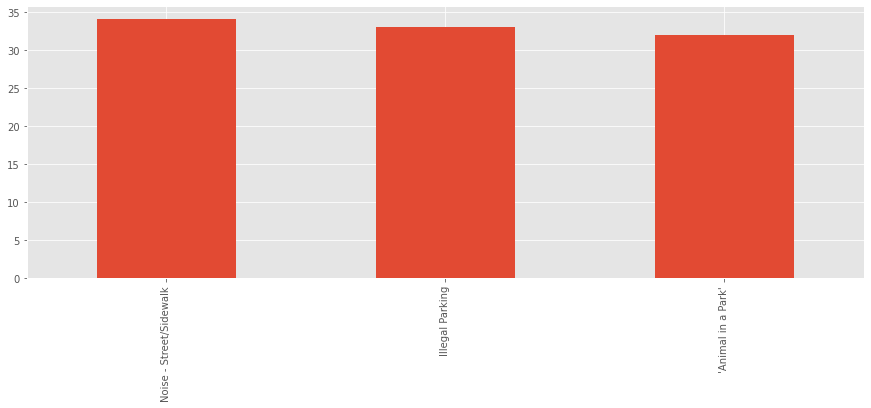

In [31]:
complaint_counts[:10].plot(kind='bar')

## Request real result

Now that we finished our analysis on the mock data, we can request this execution on the real data.

In [32]:
@sy.syft_function(input_policy=sy.ExactMatch(df=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(df):
    complaint_counts = df['Complaint Type'].value_counts()
    return complaint_counts[:10]

Create and submit project

In [33]:
new_project = sy.Project(
    name="Pandas chapter 2",
    description="Hi, I would like to plot the histogram of the complaint types.",
    members=[guest_domain_client],
)
new_project

```python
class ProjectSubmit:
  id: str = b469a45dd9a543aeb266b4e960c1d001
  name: str = "Pandas chapter 2"
  description: str = "Hi, I would like to plot the histogram of the complaint types."
  created_by: str = "jane@caltech.edu"

```

In [34]:
project = new_project.start()
assert isinstance(project, sy.service.project.project.Project)
project

```python
class Project:
  id: str = b469a45dd9a543aeb266b4e960c1d001
  name: str = "Pandas chapter 2"
  description: str = "Hi, I would like to plot the histogram of the complaint types."
  created_by: str = "jane@caltech.edu"
  events: str = []

```

In [35]:
project.create_code_request(get_counts, guest_domain_client)

<class 'syft.service.response.SyftSuccess'>: Request added successfully

In [36]:
assert len(guest_domain_client.code.get_all())==1

In [37]:
assert len(project.events) == 1

In [38]:
assert isinstance(project.events[0], sy.service.project.project.ProjectRequest)

# Data owner: execute function

In [39]:
domain_client = node.client.login(email="info@openmined.org", password="changethis")

# Get messages

In [40]:
messages = domain_client.api.services.messages.get_all_unread()

In [41]:
messages

[syft.service.message.messages.Message, syft.service.message.messages.Message]

In [42]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [43]:
request = project_message.link.events[0].request
func = request.changes[0].link
op = func.output_policy_type

In [44]:
func

```python
class UserCode:
  id: str = de4ed9c3da6341648f66412e1accd96b
  status.approved: str = "<Missing>"
  service_func_name: str = "get_counts"

```

In [45]:
get_counts_user_func = func.unsafe_function

In [46]:
real_data = domain_client.datasets[0].assets[0].data

In [47]:
real_result = get_counts_user_func(df=real_data)

In [48]:
real_result[:3]

Noise - Commercial         25
Blocked Driveway            9
Noise - Street/Sidewalk     8
Name: Complaint Type, dtype: int64

In [49]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [50]:
asset = guest_client.datasets[0].assets[0]

In [51]:
guest_client.code[0].status

{NodeView(node_name='pandas-test-domain-2', verify_key=33aa26a0331873157cb9eec982ba2cdaece2cc91e79a7fbc25877e34860f60ad): <UserCodeStatus.EXECUTE: 'execute'>}

<Axes: >

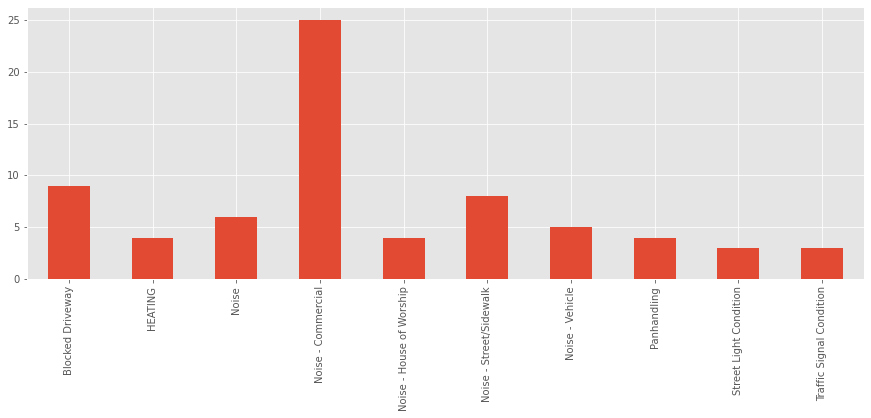

In [52]:
result_ptr = guest_client.code.get_counts(df=asset)
real_result = result_ptr.get_from(guest_client)
real_result.plot(kind="bar")

In [53]:
node.land()

Stopping pandas-test-domain-2
